Data Source: http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
%matplotlib inline

In [14]:
def read_images(data_path,target_folders,label_1_folder,reduce_height = 24,reduce_width = 21):
    """
    This function reads in all images inside the specified folders, and label the images based on label_1_folder
    data_path: the path of the folder where all the image folders reside in
    target_folders: the target_folders to be read from
    label_1_folder: images in the specified folders will be labeled with 1
    """
    # label_1_folder = [9,21]
    folder_paths = glob.glob(data_path + "*")
    images = [] # Initialize a list to record images
    labels = [] # Initialize a list to record labels
    for folder_path in folder_paths:
        index = int(folder_path[-2:]) # Get the index embeded in the folder path
        if index in target_folders:
            # Assign labels
            if index in label_1_folder:
                label =1
            else:
                label = 0

            # Read in images and corresponding labels
            img_paths = glob.glob(folder_path + "/*.pgm")
            for img_path in img_paths: 
                if img_path.find("Ambient")>0:
                    img_paths.remove(img_path) # We do not want the "Ambient" image because it is a profile picture
                else:
                    # img = plt.imread(img_path) # Used to read image without resizing
                    img_raw = Image.open(img_path) # Used when we need to resize the image (downsize in this case)
                    img_reduce = img_raw.resize((reduce_width, reduce_height), Image.BILINEAR) # Resize the image
                    img = np.array(img_reduce) # This step is necessary if we use Image.open()
                    images.append(img)
                    labels.append(label)
    return images,labels


def dark_pixel_curve(images,light_threshold = 20):
    """
    Images are taken at different lighting conditions; thus some of the photos are dark. In order to avoid 
    the impact of the bad lighting conditions, we need to remove photos with large number of dark pixels. 
    This curve shows us the number of images to be removed at different thresholds (total number of pixels 
    that are below 20 in one image). It can help us select an appropriate threshold. 
    """
    height, width = images[0].shape # Get the dimension of one image
    images_num = len(images)
    thresh_list = range(100,height*width,100) # Threshold levels to be tested: from 100 to the total pixels
    remove_list = []
    for dark_pixel_threshold in thresh_list:
        remove_count = 0
        for i in range(0,images_num):
            if sum(sum(images[i] < light_threshold)) > dark_pixel_threshold:
                remove_count = remove_count + 1
        remove_list.append(remove_count)
    
    plt.plot(thresh_list,remove_list)
    plt.xlabel("Number of dark pixels in an image")
    plt.ylabel("Number of images to be removed from the list")
    plt.title("Select the right threshold level")
    
def remove_dark_img(imgs,labels,dark_pixel_threshold,light_threshold = 20):
    """
    This function remove images that have more dark pixels (<20) than our threshold
    """
    remove_count = 0
    imgs_num = len(imgs)
    for i in range(imgs_num-1,0-1,-1):
        if sum(sum(imgs[i] < light_threshold)) > dark_pixel_threshold:
            del imgs[i]
            del labels[i]
            remove_count = remove_count + 1
    print (remove_count,' images are below our threshold and thus removed from the list')
    return imgs,labels,remove_count

def plot_images(imgs,labels):
    """
    Plot 25 images selected randomly
    """
    ind = np.random.permutation(len(imgs))

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(5, 5,figsize=(15,15))
    fig.subplots_adjust(hspace=0.1, wspace=0.01)

    for i, ax in enumerate(axes.flat): 
        ax.imshow(imgs[ind[i]], plt.cm.gray)
        xlabel = "Anomaly: {0}".format(labels[ind[i]])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

def show_anomaly_images(images,labels):
    """
    This function randomly show 9 images with label 1
    """
    anomaly_label_index = np.asarray(np.where(labels)).reshape(-1) # Get the indice of anomaly
    anomaly_image = [images[i] for i in anomaly_label_index] # Extract the images labeled as anomaly
    anomaly_label = [labels[i] for i in anomaly_label_index] # Extract the images labeled as anomaly
    plot_images(anomaly_image,anomaly_label) # Show 9 images randomly
    
def plot_eigenfaces(pca_matrix,height, width):
    """
    This function plot the eigenfaces based on the given PCA Matrix
    """
    n_eigen = pca_matrix.shape[1]
    # Define the layout of the plots
    n_row = 4
    n_col = n_eigen//n_row 

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(n_row, n_col,figsize=(15,15))
    fig.subplots_adjust(hspace=0.1, wspace=0.01)

    for i, ax in enumerate(axes.flat): 
        ax.imshow(pca_matrix[:,i].reshape(height, width), plt.cm.gray)
        xlabel = "Eigenface: {0}".format(i+1)
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

def mean_shift(components):
    """
    This function applies mean shift to each component in the component matrix
    The input components is a n*m matrix. Each row correspons to one component.
    It is important to return the components' mean vector: we will need it in PCA reconstruction
    """
    component_mean = np.mean(components,axis = 1)
    shifted_components = (components.T - component_mean).T # Necessary to take transpose twice here
    return shifted_components, component_mean

def check_eigen(eigen_value, eigen_vector,cov_matrix):
    """
    This function check the correctness of eigenvector & eigenvalue through the equation
    cov_matrix * eigen_vector = eigen_value * eigen_vector
    """
    for i in range(len(eigen_value)): 
        n = cov_matrix.shape[1]
        eigv = eigen_vector[:,i].reshape(1,n).T 
        np.testing.assert_array_almost_equal(cov_matrix.dot(eigv), eigen_value[i] * eigv, decimal=6, err_msg='', verbose=True)

## Read in Images and Remove Over-shadowed Ones

In [3]:
# Define the images to be read and the corresponding labels
label_1_folder = [9,21]
target_folders = range(1,22)
data_path = "Yale Face B/CroppedYale/"

# We also need to reduce the size of the image for the convenience of computation
reduce_height = 24
reduce_width = 21

# Read the images and reduce the size
images,labels = read_images(data_path,target_folders,label_1_folder,reduce_height,reduce_width)

# Number of labels as "Anomaly" and Total Number of Labels
sum(labels),len(labels)

(126, 1243)

(598, ' images are below our threshold and thus removed from the list')


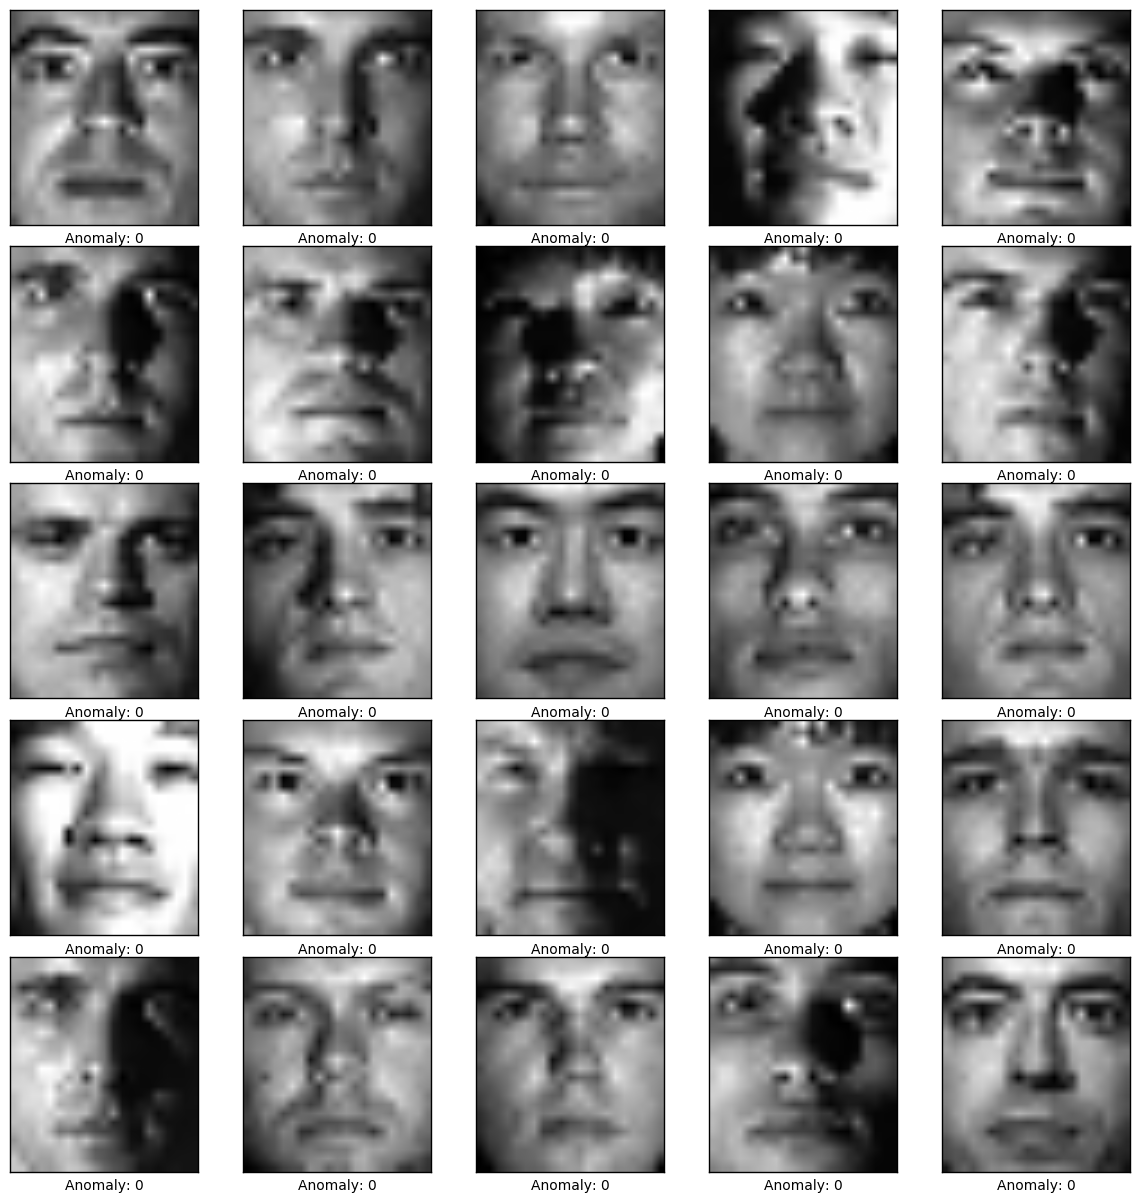

In [4]:
# To evaluate the threshold of the dark pixels
# dark_pixel_curve(images)

imgs = images[:] # Create a copy
# Eliminate the images and labels whose number of dark pixels are above the threshold
# The threshold is determined based on the dark_pixel_curve() function above
imgs,labels,remove_count = remove_dark_img(imgs,labels,180) 

plot_images(imgs,labels)

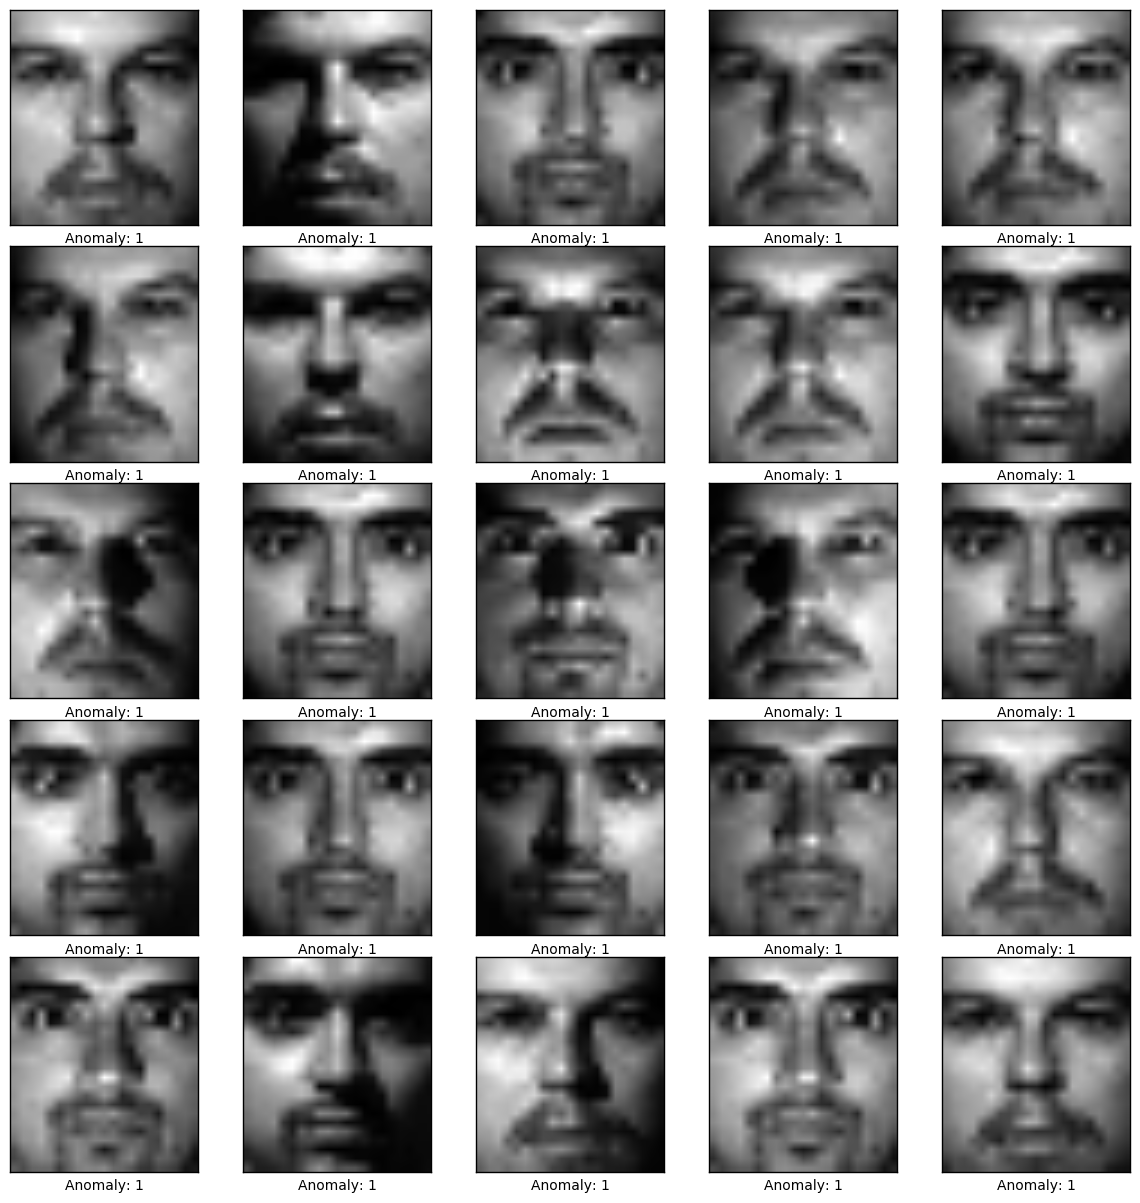

In [5]:
# Randomly select and show anomalous images
show_anomaly_images(imgs,labels)

## Apply PCA for Dimension Reduction

In [6]:
# Define the number of Principal Components we want to keep from the image
n_components = 20

# Find the dimension of one image
height, width = imgs[0].shape
num_imgs = len(imgs)
height, width,num_imgs

(24, 21, 645)

### Convert the Images List to a 2-Dimensional Matrix
Convert each image from 2D to 1D array, and each column of the new matrix will be one image.

In [7]:
# Initialize the matrix to store the entire image list
imgs_matrix = np.zeros((height*width,num_imgs)) 

# Iterate through each image, convert it into an array, and add to the imgs_matrix as a column
for i in range(0,len(imgs)):
    imgs_matrix[:,i] = imgs[i].reshape(height*width)
imgs_matrix.shape

(504, 645)

### Take a Mean-Shift
We applied the Mean-Shift on each component before computing the Covariance Matrix. It is important to save the vector of the components' mean: we will use it when we reconstruct the data after we applied PCA

In [15]:
img_matrix_shifted, component_mean = mean_shift(imgs_matrix)

### Compute the Covariance Matrix of the Image Matrix
The Covariance Matrix should be a symmetric square matrix with shape $n*n$, where $n$ is the row number of the Image Matrix, or **the number of the components**.

In [16]:
cov_matrix = np.cov(imgs_matrix)
cov_matrix.shape

(504, 504)

### Compute the eigenvectors and the corresponding eigenvalues based on the Covariance Matrix

In [17]:
# Compute the eigen value and eigen vectors
eigen_value, eigen_vector = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
# First make a list of (eigenvalue, eigenvector) tuples 
eig_pairs = [(np.abs(eigen_value[i]), eigen_vector[:,i]) for i in range(len(eigen_value))] 
# Sort the (eigenvalue, eigenvector) tuples from high to low 
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Convert the sorted eigen vector list to matrix form
eigen_vector_sorted = np.zeros((height*width,n_components))
for i in range(0,n_components):
    eigen_vector_sorted[:,i] = eig_pairs[i][1]

### Compute the PCA Matrix and Visualize the Eigenfaces

In [18]:
# Cut the sorted eigenvectors by columns to get the transformational matrix for PCA
pca_matrix = eigen_vector_sorted[:,:n_components]
pca_matrix.shape

(504, 20)

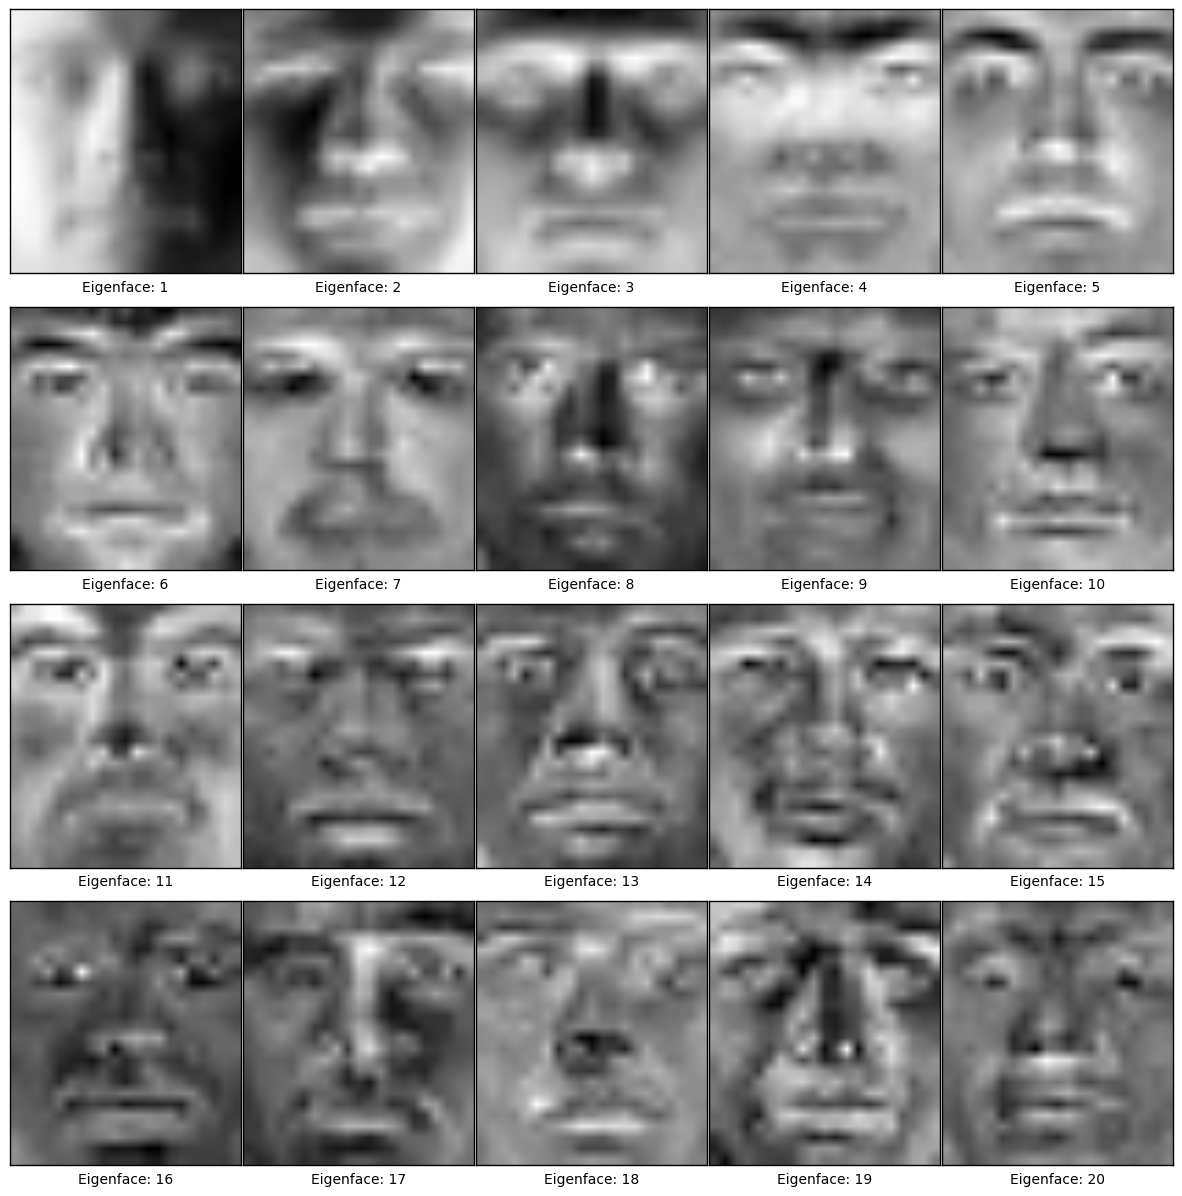

In [19]:
# Visualize the eigenfaces with the pca matrix
plot_eigenfaces(pca_matrix,height, width)

In [20]:
# Compute the transformed image
tranf_eigen = pca_matrix.T.dot(imgs_matrix)